In [1]:
!pip install pandas==2.2.2
!pip install numpy==1.26.4
!pip install matplotlib==3.8.0
!pip install scikit-learn==1.5.0
!pip install torch==2.3.1
!pip install torchvision==0.18.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 773.4 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibm-watsonx-ai 1.2.9 requires pandas<2.2.0,>=0.24.2, but you have pandas 2.2.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 8.4 MB/s eta 0:00:0000:010:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.1
    Uninstalling matplotlib-3.10.1:
      Successfully uninstalled matplotlib-3.10.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 10.5 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Suc

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
from PIL import Image

In [2]:
IMAGE_SIZE = 16

transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
transforms.ToTensor()#
composed = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

In [3]:
torchvision.datasets.FashionMNIST(root='.fashion/data', train=True, transform=composed, download=True)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: .fashion/data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(16, 16), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [4]:
# Create dataset objects for training and validation
dataset_train = torchvision.datasets.FashionMNIST(
    root='.fashion/data', train=True, transform=composed, download=True
)

dataset_val = torchvision.datasets.FashionMNIST(
    root='.fashion/data', train=False, transform=composed, download=True
)

In [5]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

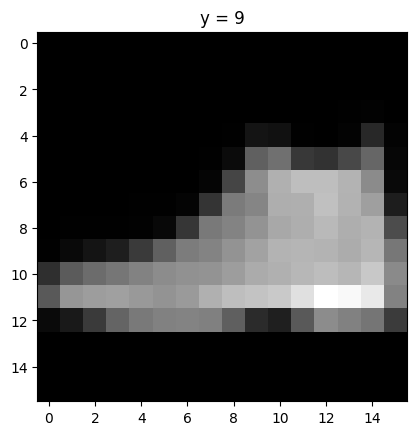

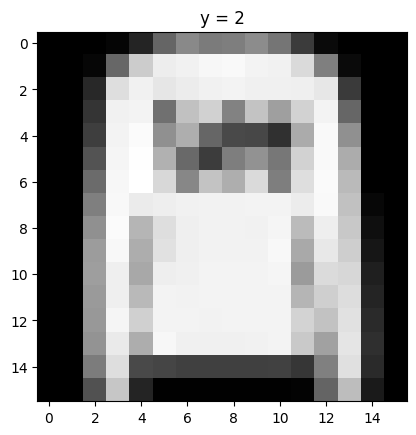

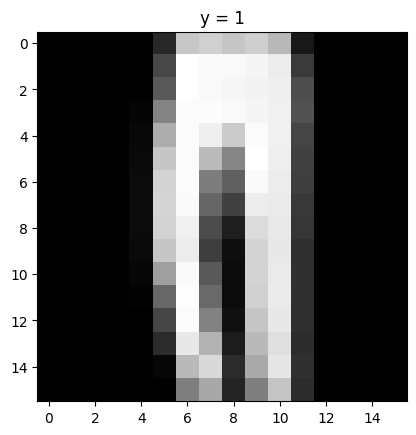

In [6]:
for n,data_sample in enumerate(dataset_val):

    show_data(data_sample)
    plt.show()
    if n==2:
        break 

In [7]:
class CNN_batch(nn.Module):
    
    # Constructor
    def __init__(self, out_1=16, out_2=32,number_of_classes=10):
        super(CNN_batch, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.conv1_bn = nn.BatchNorm2d(out_1)

        self.maxpool1=nn.MaxPool2d(kernel_size=2)
        
        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.conv2_bn = nn.BatchNorm2d(out_2)

        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)
        self.bn_fc1 = nn.BatchNorm1d(10)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x=self.conv1_bn(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x=self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x=self.bn_fc1(x)
        return x

In [8]:
class CNN(nn.Module):
    
    # Constructor
    def __init__(self, out_1=16, out_2=32,number_of_classes=10):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=5, padding=2)
        self.maxpool1=nn.MaxPool2d(kernel_size=2)

        self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=5, stride=1, padding=2)
        self.maxpool2=nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(out_2 * 4 * 4, number_of_classes)
    
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

In [9]:
train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=100 )
test_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=100 )

In [10]:
model = CNN(out_1=16, out_2=32,number_of_classes=10)
#model =CNN_batch(out_1=16, out_2=32,number_of_classes=10)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [12]:
import time
start_time = time.time()

cost_list=[]
accuracy_list=[]
N_test=len(dataset_val)
n_epochs=5
for epoch in range(n_epochs):
    cost=0
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        z = model(x)
        loss = criterion(z, y)
        loss.backward()
        optimizer.step()
        cost+=loss.item()
    correct=0
    #perform a prediction on the validation  data 
    model.eval()
    for x_test, y_test in test_loader:
        z = model(x_test)
        _, yhat = torch.max(z.data, 1)
        correct += (yhat == y_test).sum().item()
    accuracy = correct / N_test
    accuracy_list.append(accuracy)
    cost_list.append(cost)
    

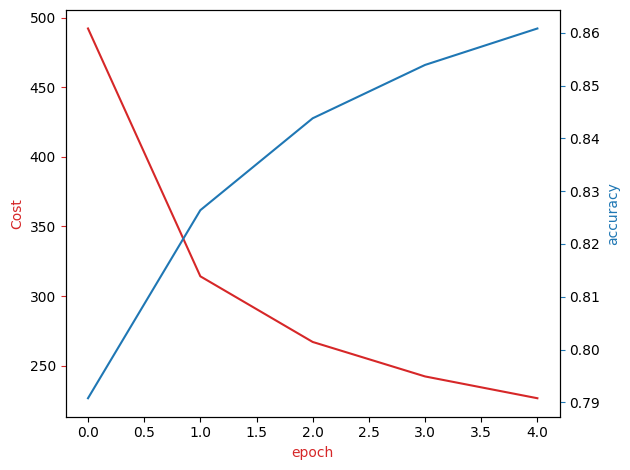

In [13]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(cost_list, color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot( accuracy_list, color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()